In [1]:
"Run this if you want to use google colab"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"Incase you don't have these."
!pip install simclr
!pip install lightning-flash
!pip install timm
!pip install torchtyping

"Download imagenette2.tgz from the link in our github repo. Add imagenette2.tgz inside your google drive."
"Uncomment if you want to use google colab"
#!tar -xvzf /content/drive/MyDrive/imagenette2.tgz

Utdata för streaming har trunkerats till de sista 5000 raderna.
imagenette2/train/n03888257/n03888257_16077.JPEG
imagenette2/train/n03888257/n03888257_23339.JPEG
imagenette2/train/n03888257/n03888257_44204.JPEG
imagenette2/train/n03888257/n03888257_61633.JPEG
imagenette2/train/n03888257/n03888257_15067.JPEG
imagenette2/train/n03888257/n03888257_75365.JPEG
imagenette2/train/n03888257/n03888257_63966.JPEG
imagenette2/train/n03888257/n03888257_3927.JPEG
imagenette2/train/n03888257/n03888257_20684.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2/train/n03888257/n03888257_14016.JPEG
imagenette2/train/n03888257/n03888257_37776.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2/train/n03888257/n03888257_17513.JPEG
imagenette2/train/n03888257/n03888257_17143.JPEG
imagenette2/train/n03888257/n03888257_6738.JPEG
imagenette2/train/n03888257/n03888257_4355.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00030583.JPEG
imagenette2/train/n03888257/n0388

In [1]:
import cv2
import os
import pathlib
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms

from flash.core.optimizers import LARS

from scipy.stats import ortho_group
from simclr.modules.transformations import TransformsSimCLR
from simclr.modules import NT_Xent
from simclr.modules.identity import Identity
from simclr.modules import LogisticRegression

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchtyping import TensorType, patch_typeguard
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import Callable, Iterator, Dict
from typeguard import typechecked

from matplotlib import pyplot as plt
from torch import linalg as LA
from tqdm import tqdm as tqdm

from timm.data import ImageDataset
from timm.data.transforms_factory import create_transform
from timm.data import create_dataset

patch_typeguard()  # use before @typechecked

In [2]:
class SimCLR(nn.Module):

    def __init__(self, encoder, projection_dim, n_features):
        super(SimCLR, self).__init__()

        self.encoder = encoder
        self.n_features = n_features

        self.encoder.fc = Identity()
        
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False, device = DEVICE),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False, device = DEVICE),
        )

    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)
        
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        
        x_i = self.encoder.conv1(x_i)
        x_i = self.encoder.bn1(x_i)
        x_i = self.encoder.relu(x_i)
        x_i = self.encoder.maxpool(x_i)
        
        #Extract the features from intermediate layers
        h_1 = self.encoder.layer1(x_i)
        h_2 = self.encoder.layer2(h_1)
        h_3 = self.encoder.layer3(h_2)
        h_4 = self.encoder.layer4(h_3)
        
        return h_i, h_j, z_i, z_j, h_1, h_2, h_3, h_4

In [3]:
image_size = 448
batch_size = 32
global_step = 0
epochs = 50
temperature = 0.2
projection_dim = 128 #128 for imagenette, 64 for CIFAR10
resnet = 'resnet18'
lr = 0.075 * np.sqrt(batch_size)
weight_decay = 1e-6
epoch_num = 100

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()
torch.manual_seed(43)

In [5]:
# To make it work in both Jupyter and standalone:
if "__file__" in globals():
    root = pathlib.Path(__file__).parent.resolve()
else:
    # Probably running interactively; in Jupyter, notebook path is
    # typically 'os.getcwd()', if it's not that's where we are going
    # to store the CIFAR data.
    root = pathlib.Path(os.getcwd())
    
"Uncomment if you want to use CIFAR10."
#train_dataset = CIFAR10(root=root, download=True, transform = TransformsSimCLR(size = image_size))

#train_loader = DataLoader(train_dataset, 
#                          batch_size, 
#                          shuffle=False,
#                          drop_last = True,
#                          num_workers=2,
#                          sampler = None)
#test_dataset = torchvision.datasets.CIFAR10(
#        root,
#        train=False,
#        download=True,
#        transform=TransformsSimCLR(size=image_size).test_transform)
#test_loader = torch.utils.data.DataLoader(
#    test_dataset,
#    batch_size=batch_size,
#    shuffle=False,
#    drop_last=True,
#    num_workers=2,
#)

"Code below loads the imagenette data set."
tim_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

imagenette_ds_train = create_dataset(name = '', root = 'imagenette2',
                                    transform = TransformsSimCLR(size = image_size))

imagenette_ds_test = create_dataset(name = '', root = 'imagenette2', 
                                    transform = tim_transform)

tim_trainloader = torch.utils.data.DataLoader(
    imagenette_ds_train,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

tim_testloader = torch.utils.data.DataLoader(
    imagenette_ds_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

In [7]:
encoder = torchvision.models.resnet18(pretrained=False) #Simply replace '18' with '50' if you want resnet 50.
n_features = encoder.fc.in_features  # get dimensions of last fully-connected layer
model = SimCLR(encoder, projection_dim, n_features).to(DEVICE)

In [9]:
optimizer = LARS(model.parameters(), lr = lr, weight_decay = weight_decay)
criterion = NT_Xent(batch_size, temperature = temperature, world_size=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       epochs, 
                                                       eta_min=0, 
                                                       last_epoch=-1)

In [10]:
@typechecked
def random_ortho_matrix_gen(dim_a: int, dim_b: int) -> Iterator[TensorType["dim_a", "dim_b"]]:
    assert dim_a >= dim_b, f"Assuming we want projection matrices (broad and short), got dims {dim_a} x {dim_b}"
    while True:
        m = ortho_group.rvs(dim=dim_a)
        for i in range(dim_a // dim_b):
            yield torch.Tensor(m[i*dim_b : (i+1)*dim_b])

@typechecked
def prior_sampler(name: str, batch_size: int, feature_dim: int) -> Callable[[], 
                                                                            TensorType["batch_size", "feature_dim"]]:
    """
    Constructs a sampling function from a named distribution. E.g., with `name=="Uniform hypersphere"`, 
    the resulting function samples `batch_size` vectors of length `feature_dim` on a uniform hypersphere.
    """
    @typechecked
    def hypersphere_sampler() -> TensorType['batch_size', 'feature_dim']:
        X = torch.normal(mean=0, std=1, size=(batch_size, feature_dim))
        return X / LA.norm(X, dim=1).unsqueeze(1)
    
    d : Dict[str,  Callable[[], TensorType["batch_size", "feature_dim"]]] = {
         "Uniform hypersphere": hypersphere_sampler, 
         "Uniform hypercube": lambda: torch.rand(size=(batch_size, feature_dim)),
         "Normal distribution": lambda: torch.normal(mean=0, std=1, size=(batch_size, feature_dim)),
        }
    if name not in d:
        raise ValueError(f"Distr '{name}' not in {d.keys()}")
    
    return d[name]

class SWD_contrastiveloss(nn.Module):
    @typechecked
    def __init__(self, batch_size: int, feature_dim: int, prior_name: str,
                 normalize_before_align: bool = True,
                 SWD_dim: int=-1, SWD_lambda: float = 1.):
        super(SWD_contrastiveloss, self).__init__()
        self.batch_size = batch_size
        self.feature_dim = feature_dim
        #self.temperature = temperature
        self.normalize_before_align = normalize_before_align
        self.sample_prior = prior_sampler(prior_name, batch_size=2*batch_size, feature_dim=feature_dim)
        self.ortho_matrix_gen = random_ortho_matrix_gen(feature_dim, SWD_dim)
        self.lmbda = SWD_lambda
        self.SWD_dim = SWD_dim
        
    @typechecked
    def forward(self, zi: TensorType["batch_size", "feature_dim"],
                zj: TensorType["batch_size", "feature_dim"]):
        # Following "Algorithm 1" in the paper
        n : int = self.batch_size
        d = zi.size(dim = -1)
        
        # Project zi/zj onto hypersphere (i.e. normalize).
        if self.normalize_before_align:
            zi = zi / LA.norm(zi, dim=1).unsqueeze(1)
            zj = zj / LA.norm(zj, dim=1).unsqueeze(1)
        loss_align = ((zi - zj)**2).sum() / (n*d)
        Z : TensorType[2*self.batch_size, self.feature_dim] = torch.cat((zi, zj), dim=0).to(DEVICE)
        P : TensorType[2*self.batch_size, self.feature_dim] = self.sample_prior().to(DEVICE)
        W : TensorType[self.feature_dim, self.SWD_dim] = next(self.ortho_matrix_gen).to(DEVICE)
        
        
        H_perp, P_perp = Z @ W, P @ W 
        #loss_distr = torch.Tensor(0.) #Getting compiler error if we do like that, solution done below.
        loss_distr = 0 #commented out torch.Tensor since we are supposed to get a singular value anyway.
        for j in range(self.SWD_dim):
            hj, pj = H_perp[:, j], P_perp[:, j]
            hj, _ = torch.sort(hj)
            pj, _ = torch.sort(pj)
            loss_distr = loss_distr + ((hj - pj)**2).sum()
        loss_distr = loss_distr / (self.feature_dim * self.SWD_dim)
        return loss_align + self.lmbda * loss_distr
    
swd_normal_crit = SWD_contrastiveloss(batch_size, normalize_before_align=False, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Normal distribution")
swd_cube_crit = SWD_contrastiveloss(batch_size, normalize_before_align=False, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Uniform hypercube")
swd_sphere_crit = SWD_contrastiveloss(batch_size, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Uniform hypersphere")


In [11]:
def train(global_step, loader, model, criterion, optimizer, writer):
    loss_epoch = 0
    for steps, ((x_i, x_j), _) in enumerate(loader):
        x_i = x_i.to(DEVICE)
        x_j = x_j.to(DEVICE)
        
        optimizer.zero_grad()
        h_i, h_j, z_i, z_j, h_1, h_2, h_3, h_4 = model(x_i, x_j)

        loss = criterion(z_i, z_j)
        loss.backward()
        optimizer.step()

        if steps % 50 == 0:
            print(f"Step [{steps}/{len(loader)}]\t Loss: {loss.item()}")

        writer.add_scalar("Loss/train_epoch", loss.item(), global_step)
        loss_epoch += loss.item()
        global_step += 1
    return loss_epoch

In [12]:
"Run this cell if you want to train the model."
for epoch in tqdm(range(epochs)):
    loss_epoch = train(global_step, tim_trainloader, model, criterion, optimizer, writer)
    scheduler.step()
    writer.add_scalar("Loss/train", loss_epoch / len(tim_trainloader), epoch)
    print(
        f"Epoch [{epoch}/{epochs}]\t Loss: {loss_epoch / len(tim_trainloader)}\t"
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Step [0/122]	 Loss: 4.143771171569824


  0%|          | 0/5 [00:19<?, ?it/s]


KeyboardInterrupt: ignored

In [13]:
def inference(loader, simclr_model, device):
    feature_vector = []
    labels_vector = []
    
    feature_vector_blocks = [[] for i in range(4)]

    for step, (x, y) in enumerate(loader):
        
        x = x.to(DEVICE)

        # get encoding
        with torch.no_grad():
            h, _, z, _, h_1, h_2, h_3, h_4 = simclr_model(x, x)

        h = h.detach()
        h_blocks = [h_1, h_2, h_3, h_4]
        for j, i in enumerate(h_blocks):
            i = i.detach()
            feature_vector_blocks[j].extend(i.cpu().detach().numpy())

        feature_vector.extend(h.cpu().detach().numpy())    
        labels_vector.extend(y.numpy())

        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
            
        if step == 10:
            break

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    
    for i in range(len(feature_vector_blocks)):
        feature_vector_blocks[i] = np.array(feature_vector_blocks[i])
    
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector, feature_vector_blocks

def get_features(context_model, train_loader, test_loader, device):
    train_X, train_y, _ = inference(train_loader, context_model, device)
    test_X, test_y, test_blocks = inference(test_loader, context_model, device)
    return train_X, train_y, test_X, test_y, test_blocks 


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, block_test, batch_size):
    test1 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[0]), torch.from_numpy(y_test)
    )
    test2 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[1]), torch.from_numpy(y_test)
    )
    
    test3 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[2]), torch.from_numpy(y_test)
    )
    test4 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[3]), torch.from_numpy(y_test)
    )

    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )

    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=batch_size, shuffle=False
    )
    
    return train_loader, test_loader, test1, test2, test3, test4

In [14]:
def k_means_on_img(image, k, max_iter=100, epsilon=0.2, attempts=10, normalize=False, plot=False):
    flag = cv2.KMEANS_RANDOM_CENTERS
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if plot:
        # show the image
        plt.imshow(image)
        plt.show()

    if normalize:
        # normalize img to 0-255
        norm_image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        image = norm_image.astype(np.uint8)

    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    
    # some documentation -> https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, attempts, flag)
    
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()
    
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    
    if plot:
        # show the image
        plt.imshow(segmented_image)
        plt.show()
    return segmented_image

In [15]:
imagenette_ds_train = create_dataset(name = '', root = 'imagenette2',
                                    transform = tim_transform)

tim_loader = torch.utils.data.DataLoader(
    imagenette_ds_train,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

In [16]:
print("### Creating features from pre-trained context model ###")
train_X, train_y, test_X, test_y, test_blocks = get_features(model, tim_loader, tim_testloader, DEVICE)
arr_train_loader, arr_test_loader, block_1, block_2, block_3, block_4 = create_data_loaders_from_arrays(train_X, train_y, test_X, test_y, test_blocks, batch_size)

### Creating features from pre-trained context model ###
Step [0/122]	 Computing features...
Features shape (352, 512)
Step [0/122]	 Computing features...
Features shape (352, 512)


In [ ]:

def train(loader, simclr_model, logmodel, criterion, optimizer):
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (x, y) in enumerate(loader):
        optimizer.zero_grad()

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        output = logmodel(x)
        loss = criterion(output, y)

        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc

        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

    return loss_epoch, accuracy_epoch

def test(loader, simclr_model, logmodel, criterion, optimizer):
    loss_epoch = 0
    accuracy_epoch = 0
    logmodel.eval()
    for step, (x, y) in enumerate(loader):
        logmodel.zero_grad()

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        output = logmodel(x)
        loss = criterion(output, y)

        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc

        loss_epoch += loss.item()

    return loss_epoch, accuracy_epoch

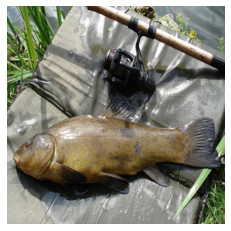

In [20]:
for images, _ in imagenette_ds_test:
    batch = images.cpu().detach().numpy()
    batch = np.moveaxis(batch, 0, -1)
    plt.axis('off')
    plt.imshow(batch)
    plt.imsave('fish.jpg', batch)
    break

In [25]:
for images, _ in block_1:
    print('images.shape:', images.shape)

    image = images.cpu().detach().numpy()
    image = np.moveaxis(image, 0, -1)
    np.save('block1.npy', image)

    k = 2
    segmented_image = k_means_on_img(image, k, max_iter=100, epsilon=0.2, 
                                     attempts=10, normalize=True, 
                                     plot=True)
    break

images.shape: torch.Size([64, 112, 112])


error: ignored

images.shape: torch.Size([128, 56, 56])


error: ignored

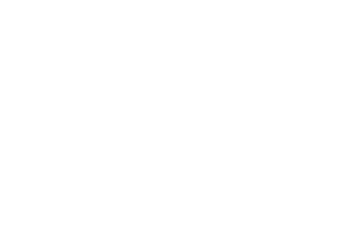

In [22]:
for images, _ in block_2:
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    np.save('block2.npy', image)

    k = 2
    plt.axis('off')
    
    segmented_image = k_means_on_img(image, k, max_iter=100, epsilon=0.2, 
                                     attempts=10, normalize=True, 
                                     plot=True)
    break

images.shape: torch.Size([256, 28, 28])


error: ignored

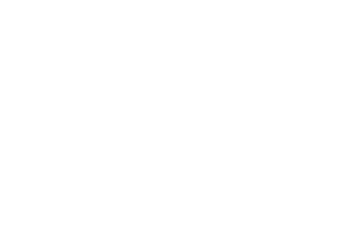

In [26]:
for images, _ in block_3:
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    np.save('block3.npy', image)

    plt.axis('off')
    k = 2
    segmented_image = k_means_on_img(image, k, max_iter=100, epsilon=0.2, 
                                     attempts=10, normalize=True, 
                                     plot=True)
    break

images.shape: torch.Size([512, 14, 14])


error: ignored

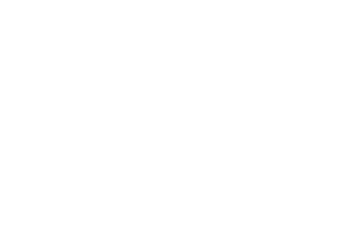

In [27]:
for images, _ in block_4:
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    np.save('block4.npy', image)

    plt.axis('off')
    k = 2
    segmented_image = k_means_on_img(image, k, max_iter=100, epsilon=0.2, 
                                     attempts=10, normalize=True, 
                                     plot=True)
    break